# TESTING PHASE (ONLY LSM)

## Tests the readouts weights using new simulations instead of the training data

# It's necessary to run:
# ulimit -S -n 8192
# before the ipython notebook in order to make sure the "too many files open" error is not going to appear during larger simulations.

In [1]:
import sys
from BEE import * # https://github.com/ricardodeazambuja/BEE

In [3]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

    
# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy

import save_load_file as slf # https://github.com/ricardodeazambuja/Python-UTILS

In [5]:
#
# Controls if the results are saved to a file
#

save2file = False

# Initialization and functions necessary to the 2 DOF arm simulations

In [6]:
sim_set = "experiment_0001" # basically is the name of the folder where the data is read/saved
base_dir = "simulation_data_00003"

In [7]:
# This data must follow what was used to generate the trajectories
# or the arm model will behave differently!

# Total time spent during the movement (in seconds)
MT = 2.0

# Simulation time step (in seconds)
time_step = 2/1000.0

total_steps = int(MT/time_step)


In [8]:
# S0, S1, E1 and W1 are the Baxter's joint names
# Four joints => four input variables
Number_of_input_variables=4 # defines how the liquid is going to be divided to receive the inputs

In [9]:
#
# Number of neurons at each input layer (defines the INPUT resolution of the system)
#
# >>>>>>>>> It MUST be smaller or equal to (NofN/Number_of_input_variables) <<<<<<<<<<<
#
Ninput = 150

In [10]:
original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...

temp=numpy.load(base_dir+"/"+sim_set+"/XY_movement_square.npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))

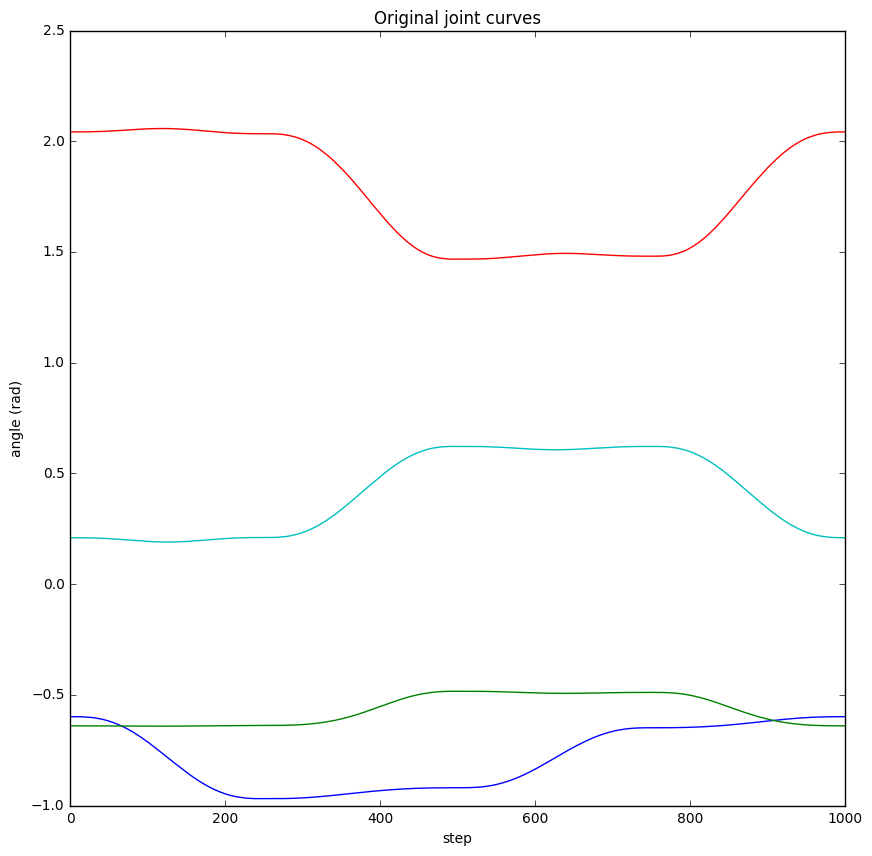

In [11]:
plt.figure(figsize=(10,10))
plt.plot(original_joints)
plt.title("Original joint curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")
plt.show()

In [12]:
joints=numpy.copy(original_joints)
joints[0,:]

array([-0.59881723, -0.64028174,  2.04201794,  0.20936455])

# In order to ONLY verify saved results, jump directly to the end of the notebook
*[Results visualisation](#plot)

# Configure the liquid

In [11]:
liqseeds = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")
number_of_liquids = len(liqseeds)
for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [8151 4134 3840 4248 1353 7718]
Liquid 1: [5285 1067 2851  158  672 9688]
Liquid 2: [2981 5505 7474 1449 3473 9496]
Liquid 3: [4926 7048 1558 1884 4054 8442]
Liquid 4: [5165 5248 3543 5505  104 1396]


In [12]:
def generates_connections(liqseeds,lsm_i,neuron_params):
    
    disconnected,membrane_rand,current_rand,noisy_current_rand,SpkLiq_vresets_rand,lbd_value,parameter_list=neuron_params

    #
    # Liquid's shape
    #

    # Liquid's shape
    net_shape = numpy.array([20,5,6])

    # Random seeds:
    # // RANDOM-1: Noisy offset currents / resets
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons
    # // RANDOM-3: Internal connections of the liquid
    RANDOM_1=liqseeds[lsm_i][1]
    RANDOM_2=liqseeds[lsm_i][2]
    RANDOM_3=liqseeds[lsm_i][3]
    #DEBUG!
    # RANDOM_4=liqseeds[lsm_i][4]
    # RANDOM_0=liqseeds[lsm_i][0]

    input_noise_std = 1 # Standard deviation of the input gaussian noise

    # Neuron parameters
    taum=0.03 # membrane time constant
    cm=3e-08 # membrane capacitance
    taue=0.003 # excitatory synapse time constant
    taui=0.006 # inhibitory synapse time constant


    
    input_gain=105. # gain used for the input neurons
    w_SD = 3.0 # input neurons standard deviation


    #
    # END OF THE SETUP - everything that should change between liquids is expressed above...
    #


    #
    # This first initialization of the simulator is only used to generate the liquid structure's data
    #

    # Resets the simulator
    BEE_free()

    tstp = time_step

    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons
    # // RANDOM-3: Internal connections of the liquid
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3


    if not BEE_initialized():
        initialize_sim(my_net_shape = net_shape, \
                       my_lbd_value = lbd_value, \
                       my_seeds=seeds, \
                       SpkLiq_step=time_step,\
                       SpkLiq_threads_N = 5,\
                       SpkLiq_vresets = SpkLiq_vresets_rand,\
                       SpkLiq_membrane_rand=membrane_rand,\
                       SpkLiq_current_rand=current_rand,\
                       SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                       SpkLiq_noisy_current_rand=noisy_current_rand)


    if parameter_list!=[]:
        change_parameters(parameter_list)

    if BEE_initialized() and (not BEE_connected()):
        generate_connections()

    #
    # Cancels the connections, but keeps the parameters
    #
    if disconnected:
        BEE_writes_SpkLiq_inh_connections(0)
        BEE_writes_SpkLiq_exc_connections(0)

    if BEE_initialized() and (not BEE_connected()):
        process_connections()

    NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats(stats=0)


    #
    # Input converter
    # 

    # This information is used to define the neurons receiving inputs (excitatory neurons):
    inhibitory_index_L = output_inh_indices(NoINHN)
    inhibitory_index_L.shape

    inhibitory_index_L=[] # input signals through all neurons (not only excitatory ones)

    #
    # Input pattern generation
    # 

    Number_of_neurons_lsm = NofN
    Number_of_input_layers = Number_of_input_variables
    Number_of_neurons_inputs = Ninput



    # 
    # Gaussian generation
    #

    #
    # Generates the connection pattern used. In the case below it's a gaussian 
    # distributed one based on the connection weights.
    #

    # In order to use SpiNNaker I should change from weight based to spike based (like in Oliveri's article).

    inputs_indices = [] #inputs_indices[input_variable][ni]
    inputs_weights = [] #inputs_weights[input_variable][ni]


    def gaussian(lamb,n,nt):
        '''
        Generates a gaussian centered at 'n'
        '''
        return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

    weight_func = gaussian


    liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

    # Goes through the liquid to generate the proper connections, 
    # but dividing the liquid into the same number of input layers.
    # Each input layer only connects to its own slice of the liquid.

    centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

    for inp in range(Number_of_input_layers): #goes through the input layers
        temp_i=[]
        temp_w=[]        
        for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                        range(Number_of_neurons_inputs)): #goes through the input neurons
            temp_i2 = []
            temp_w2 = []
            for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                            range(liquid_input_layer_size)):
                if j not in inhibitory_index_L:
                    centre_position=centre_positions[ic]
                    temp_weight=weight_func(w_SD,centre_position,ji)             
                    if temp_weight>0: #guaranties only real spikes will be injected, saving cpu time
                        temp_w2.append(temp_weight) # in nA
                        temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron                                        
            temp_i.append(temp_i2)
            temp_w.append(temp_w2)
        inputs_indices.append(temp_i)
        inputs_weights.append(temp_w)
    
    return (inputs_indices,inputs_weights)

# This is the simulation to test the readout

In [13]:
def loads_coeffs(lsm_i,disconnected=0):
    
    extra_name=str(lsm_i)+"_Modular"

    filenames = ["./"+base_dir+"/"+sim_set+"/coefficients_residues_"+str(var_name)+"_linear"+extra_name+".pickle" \
                 for var_name in ['s0','s1','e1','w1']]

    # Make sure the coefficients were created for the right size of network...
    [c_s0,r_s0] = slf.load_from_file(filenames[0])
    [c_s1,r_s1] = slf.load_from_file(filenames[1])
    [c_e1,r_e1] = slf.load_from_file(filenames[2])
    [c_w1,r_w1] = slf.load_from_file(filenames[3])

    ranges_vector=slf.load_from_file("./"+base_dir+"/"+sim_set+"/ranges_0.pickle")
    bias_vector=slf.load_from_file("./"+base_dir+"/"+sim_set+"/bias_0.pickle")
    
    return ((c_s0,c_s1,c_e1,c_w1,r_s0,r_s1,r_e1,r_w1),(bias_vector,ranges_vector))

In [14]:
from multiprocessing import Process, Pipe

def simulator(args):
        import sys
        import BEE as BEE_python
        
        import membrane_lowpass_md
        membrane_lowpass = membrane_lowpass_md.membrane_lowpass

        import numpy
        
        #import os
        #sys.stdout = open(str(os.getpid()) + ".out", "a", buffering=0)
        
        pipes, sim_args = args
        pipe_in,pipe_out = pipes
        
        # The seeds array must be a numpy.array, int32 with 5 terms.
        pi,neuron_params,bias_vector,ranges_vector,inputs_indices,inputs_weights,coeffs,seeds, disconnected_neurons_indices = sim_args
        
        disconnected,membrane_rand,current_rand,noisy_current_rand,SpkLiq_vresets_rand,lbd_value,parameter_list = neuron_params
        
        c_s0,c_s1,c_e1,c_w1,r_s0,r_s1,r_e1,r_w1 = coeffs


        #
        # Liquid's shape
        #
        net_shape = numpy.array([20,5,6])
        
        # S0, S1, E1 and W1
        Number_of_input_variables=4 # defines how the liquid is going to be divided to receive the inputs        

        # Number of neurons at each input layer (defines the INPUT resolution of the system)
        Ninput = 150

        # Simulation time step (in seconds)
        time_step = 2/1000.0

        # This is the trajectory I want to test. It goes from 0 to 3
        tji=0

        number_of_joints = 4

        # Creates the Ninput possible discrete values of angle for each joint
        joints_values=numpy.empty((Ninput,number_of_joints))
        for ji in range(number_of_joints):
            joints_values[:,ji]=numpy.linspace(-1,1,Ninput)
            

        # Neuron parameters
        taum=0.03 # membrane time constant
        cm=3e-08 # membrane capacitance
        taue=0.003 # excitatory synapse time constant
        taui=0.006 # inhibitory synapse time constant    
             

        # Resets the simulator
        BEE_python.BEE_free()
        # It was only BEE_free...

        # print "Initializing the simulator..."
        if not BEE_python.BEE_initialized():
            BEE_python.initialize_sim(my_net_shape = net_shape, \
                                      my_lbd_value = lbd_value, \
                                      my_seeds=seeds, \
                                      SpkLiq_step=time_step,\
                                      SpkLiq_threads_N = 5,\
                                      SpkLiq_vresets = SpkLiq_vresets_rand,\
                                      SpkLiq_membrane_rand=membrane_rand,\
                                      SpkLiq_current_rand=current_rand,\
                                      SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                                      SpkLiq_noisy_current_rand=noisy_current_rand)


        if parameter_list!=[]:
            BEE_python.change_parameters(parameter_list)

        BEE_python.generate_connections()

        #
        # Cancels the connections, but keeps the parameters
        #
        if disconnected:
            BEE_python.BEE_writes_SpkLiq_inh_connections(0)
            BEE_python.BEE_writes_SpkLiq_exc_connections(0)


        BEE_python.process_connections()

        # print "Verifies..."
        NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=BEE_python.output_stats(stats=0)

        connected_neurons_indices = numpy.ones(NofN,dtype=numpy.int32)
        
        if len(disconnected_neurons_indices) != 0:
            connected_neurons_indices[disconnected_neurons_indices] = numpy.zeros(len(disconnected_neurons_indices),dtype=numpy.int32)
            
        
        # Forces the simulator to calculate the values for all neurons (even the unconnected ones)
        # This is important during the tests without connections
        BEE_python.control_connected(connected_neurons_indices)

        
        # DEBUG #
        # print BEE_python.output_connected(NofN)
        # sys.exit(0)
        # DEBUG #
        
        
        # run_test
        using_spikes = 0
        membrane_time_constant = 30E-3
        

        #BEE_python.liquid_soft_reset(seeds) # Resets the simulator

        # Initialize
        ti=0

        m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane

        # Runs the simulation going step-by-step
        # Stops at the yield keyword!
        # I want to receive joint angles (the average) and return the result from the LSM
        
        pipe_out.send("LSM %d Ready!"%pi)
        
        while True:
            
            input_angles = pipe_in.recv() # receives the joint values... blocks until something arrives
            
            if input_angles:
                joint_s0,joint_s1,joint_e1,joint_w1 = input_angles
            
                s0_value = (joint_s0-bias_vector[0])/ranges_vector[0]
                s1_value = (joint_s1-bias_vector[1])/ranges_vector[1]
                e1_value = (joint_e1-bias_vector[2])/ranges_vector[2]
                w1_value = (joint_w1-bias_vector[3])/ranges_vector[3]

                input_spikes = [abs(joints_values[:,0]-s0_value).argmin(),\
                                abs(joints_values[:,1]-s1_value).argmin(),\
                                abs(joints_values[:,2]-e1_value).argmin(),\
                                abs(joints_values[:,3]-w1_value).argmin()]

                exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
                inh_inputs = []
                exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
                inh_weights = []

                # Here the simulator is receiving the input spikes (and returning the output ones):
                # r, current_t, received_spikes, OutputSpks, t = s.run_step(input_spikes) # Sends the spikes and reads the output
                BEE_python.updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs), 0)

            else: # the input was None - useful to compare with SpiNNaker
                BEE_python.updates_sim([], [], [], [], 0, 0)

            # reads LSM the output
            OutputSpks = BEE_python.reads_spikes(NofN)
            
            # DEBUG #
            #if len(OutputSpks):
            #    print str(len(OutputSpks)) + "-",
            #    sys.stdout.flush()
            # DEBUG # 

            if using_spikes:
                Output = numpy.zeros(NofN) 
                Output[OutputSpks]=1 # Using the output of the liquid directly
            else:
                m_v.process_spikes(OutputSpks,ti) # Send the spikes to the membrane filter
                Output = m_v.check_values(ti) # Reads the values of the membranes
        
            joint_s0=(bias_vector[0]+(Output.dot(c_s0)+r_s0)*ranges_vector[0]) # Calculates the joint angles from the membrane filtered values
            joint_s1=(bias_vector[1]+(Output.dot(c_s1)+r_s1)*ranges_vector[1]) # Calculates the joint angles from the membrane filtered values
            joint_e1=(bias_vector[2]+(Output.dot(c_e1)+r_e1)*ranges_vector[2]) # Calculates the joint angles from the membrane filtered values
            joint_w1=(bias_vector[3]+(Output.dot(c_w1)+r_w1)*ranges_vector[3]) # Calculates the joint angles from the membrane filtered values

            ti+=time_step # advances the time
            
            pipe_out.send([[joint_s0,joint_s1,joint_e1,joint_w1],OutputSpks,Output,ti])

# New trials start here

In [15]:
def kill_processes(new_sim,new_pipes_in,new_pipes_out):
    #
    # Kills the processes!
    #
    for i in range(len(new_sim)):
        new_sim[i].terminate()
        new_pipes_in[i][0].close()
        new_pipes_in[i][1].close()        
        new_pipes_out[i][0].close()
        new_pipes_out[i][0].close()        
        while new_sim[i].is_alive():
            pass
        # print "Process %d is dead!" % i

    del new_sim
    del new_pipes_in
    del new_pipes_out

In [16]:
def initialize_LSM(total_parallel = 10, total_lsms = 0, lsm_i = 0, disconnected_neurons = []):
    #
    # Initialization of the LSM's
    #
    #total_parallel: total number of liquids to be used in PARALLEL (it is going to copy liquids if there aren't enough)
    #
    #total_lsms: len(liqseeds) # number of different LSMs available
    #total_lsms: 0 Indicates one LSM is going to be used even if there are more available
    #lsm_i: then it's number should be specified here (lsm_i), otherwise lsm_i is redefined inside this function


    # Parameters paper Joshi/Maass
    membrane_rand=[13.5E-3,14.9E-3]
    current_rand=[13.5E-09, 14.5E-09]
    noisy_current_rand=1E-9

    factor=2*10.0

    SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution

    lbd_value = 1.2

    parameter_list=\
    [[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
      [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
     [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
      [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]


    disconnected = 0

    neuron_params = disconnected,\
                    membrane_rand,\
                    current_rand,\
                    noisy_current_rand,\
                    SpkLiq_vresets_rand,\
                    lbd_value,\
                    parameter_list



    lsm_circ_arr = numpy.arange(total_lsms,dtype=numpy.int)

    new_sim = []
    new_pipes_in = []
    new_pipes_out = []
    joint_angles_mean = []
    for i in range(total_parallel):
        if total_lsms>0:
            lsm_i = numpy.roll(lsm_circ_arr,-i)[0] # If you want to use always the same, do total_lsms=0 and set lsm_i.
        new_pipes_in.append(Pipe(duplex=False))
        new_pipes_out.append(Pipe(duplex=False))

        coeffs, (bias_vector,ranges_vector) = loads_coeffs(lsm_i)

        inputs_indices,inputs_weights = generates_connections(liqseeds,lsm_i,neuron_params)

        seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
        # // RANDOM-0: Membrane initial potentials
        # // RANDOM-1: Noisy offset currents / resets <<<<<<
        # // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<
        # // RANDOM-3: Internal connections of the liquid <<<<<<
        # // RANDOM-4: Noisy corrents    
        #seeds[0] = liqseeds[lsm_i][0]
        seeds[1] = liqseeds[lsm_i][1]
        seeds[2] = liqseeds[lsm_i][2]
        seeds[3] = liqseeds[lsm_i][3]
        #seeds[4] = liqseeds[lsm_i][4]                
        new_sim.append(Process(target=simulator, args=(((new_pipes_in[i][0], new_pipes_out[i][1]),\
                                                        (lsm_i,neuron_params,\
                                                         bias_vector,ranges_vector,\
                                                         inputs_indices,inputs_weights,\
                                                         coeffs,numpy.copy(seeds[:5]),disconnected_neurons[lsm_i])),)))

    for i in range(total_parallel):
        new_sim[i].daemon = True
        new_sim[i].start()
    
    return new_sim, new_pipes_in, new_pipes_out, bias_vector, ranges_vector

    # [Errno 24] Too many open files
    # Try the command line tools:
    # ulimit -a
    # lsof | grep PIPE
    # lsof | grep PIPE | grep -c Python
    # What solved my problem was the use of:
    # ulimit -S -n 8192 
    # just before starting the ipython notebook...

In [17]:
def unlock_processes(new_sim,new_pipes_out):
    #
    # Unlock the processes
    #
    for i in range(len(new_sim)):
        if new_sim[i].is_alive():
            temp = new_pipes_out[i][0].recv() # unlocks the process
            #print "Process %d: %s" % (i,temp)
        else:
            pass
            #print "%d - No processes to unlock!" % i

In [18]:
def run_trial(new_sim, new_pipes_in, new_pipes_out, simulation_type, trial_number, number_of_steps = 2000):
    if simulation_type=="parallel":
        #
        # This version feeds back average values
        #
        # Each LSM receives the average of all the outputs.

        joint_angles_individual = []
        for i in range(len(new_sim)):
            joint_angles_individual.append([])

        for j in range(number_of_steps):
            joint_angles = []    
            for i in range(len(new_sim)):
                [joint_s0,joint_s1,joint_e1,joint_w1] = joint_angles_mean[-1]
                new_pipes_in[i][1].send([joint_s0,joint_s1,joint_e1,joint_w1])
                ([joint_s0,joint_s1,joint_e1,joint_w1],OutputSpks,_,ti) = new_pipes_out[i][0].recv()
                joint_angles.append([joint_s0,joint_s1,joint_e1,joint_w1])
                joint_angles_individual[i].append([joint_s0,joint_s1,joint_e1,joint_w1])

            joint_angles_mean.append(numpy.array(joint_angles).mean(axis=0))

    return joint_angles_mean,joint_angles_individual

# Generation of the testing data using different configurations


In [19]:
%%time
#
# USING ALL THE AVAILABLE LIQUIDS
#

NofN = 600

number_of_trials = 100

temp = numpy.arange(NofN)

for number_of_decimated_neurons in numpy.arange(11)*6:

    extra_name = "_Modular_decNeurons_"+str(number_of_decimated_neurons)+"_"

    simulation_type = "parallel"

    parallel_lsms = 5

    for trial_number in range(number_of_trials):
        #
        # Sets the initial joint angles => joints[0,:]
        #
        joint_angles_mean = []
        joint_angles_mean.append(joints[0,:])   
        
        disconnected_neurons = []
        
        # Sets the disconnected neurons (randomly)
        for lsm_i in range(parallel_lsms):
            numpy.random.shuffle(temp)
            disconnected_neurons.append(numpy.copy(temp[:number_of_decimated_neurons]))
            

        new_sim,new_pipes_in,new_pipes_out,bias_vector,ranges_vector = initialize_LSM(total_parallel = parallel_lsms, \
                                                                                      total_lsms = len(liqseeds), lsm_i = 0,\
                                                                                     disconnected_neurons = disconnected_neurons)
        unlock_processes(new_sim,new_pipes_out)
        joint_angles_mean,joint_angles_individual = run_trial(new_sim,new_pipes_in,new_pipes_out,simulation_type,trial_number)
        kill_processes(new_sim,new_pipes_in,new_pipes_out)

        filename = "./"+base_dir+"/"+sim_set+"/joint_angles_mean_"+simulation_type+"_ALL_"+str(trial_number)+extra_name+"_LSM.npy"
        if save2file:
            numpy.save(filename,joint_angles_mean)

        filename = "./"+base_dir+"/"+sim_set+"/joint_angles_individual"+simulation_type+"_ALL_"+str(trial_number)+extra_name+"_LSM.npy"
        if save2file:
            numpy.save(filename,joint_angles_individual)


CPU times: user 1h 14min 9s, sys: 6min 31s, total: 1h 20min 41s
Wall time: 3h 43min 26s


In [26]:
numpy.arange(11)*6

array([ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60])

# Plotting the results using the generated files (above)
<a id="plot"></a>

In [23]:
extra_name = "_Modular_decNeurons_0_"
simulation_type = "parallel"

lsm_i = "ALL"

number_of_trials = 100

joint_angles_mean = []
for ti in range(number_of_trials):
    filename = "./"+base_dir+"/"+sim_set+"/joint_angles_mean_"+simulation_type+"_"+str(lsm_i)+"_"+str(ti)+extra_name+"_LSM.npy"
    joint_angles_mean.append(numpy.load(filename))

ranges_vector=slf.load_from_file("./"+base_dir+"/"+sim_set+"/ranges_0.pickle")
bias_vector=slf.load_from_file("./"+base_dir+"/"+sim_set+"/bias_0.pickle")


In [24]:
simulation_results = numpy.array(joint_angles_mean)

In [1]:
joint_names = ["s0","s1","e1","w1"]
plt.figure(figsize =(30,30))
for ji in range(4):
    plt.subplot(411+ji)
    for si in simulation_results:
        plt.plot(si[:,ji],'g-',linewidth=2,label="Calculated")
    plt.plot(joints[:,ji],'b-',linewidth=4,label="Original")
    plt.title("Joint "+joint_names[ji])
#     plt.xlim(0,len(t_mov)-2)

plt.show()